Applying different cleaning methods...

Cleaning Quality Metrics:
--------------------------------------------------
Median Filter:
  Smoothness: 1.375
  Noise Reduction: 1.01x
  Data Preservation: 0.894
  MSE Improvement: 50.379

Modified Z-Score:
  Smoothness: 16.936
  Noise Reduction: 1.00x
  Data Preservation: 1.000
  MSE Improvement: 0.000

Hampel Filter:
  Smoothness: 4.569
  Noise Reduction: 1.01x
  Data Preservation: 0.929
  MSE Improvement: 48.288

Savitzky-Golay:
  Smoothness: 2.183
  Noise Reduction: 1.06x
  Data Preservation: 0.855
  MSE Improvement: 39.371

Combined Pipeline:
  Smoothness: 1.239
  Noise Reduction: 1.01x
  Data Preservation: 0.880
  MSE Improvement: 50.196



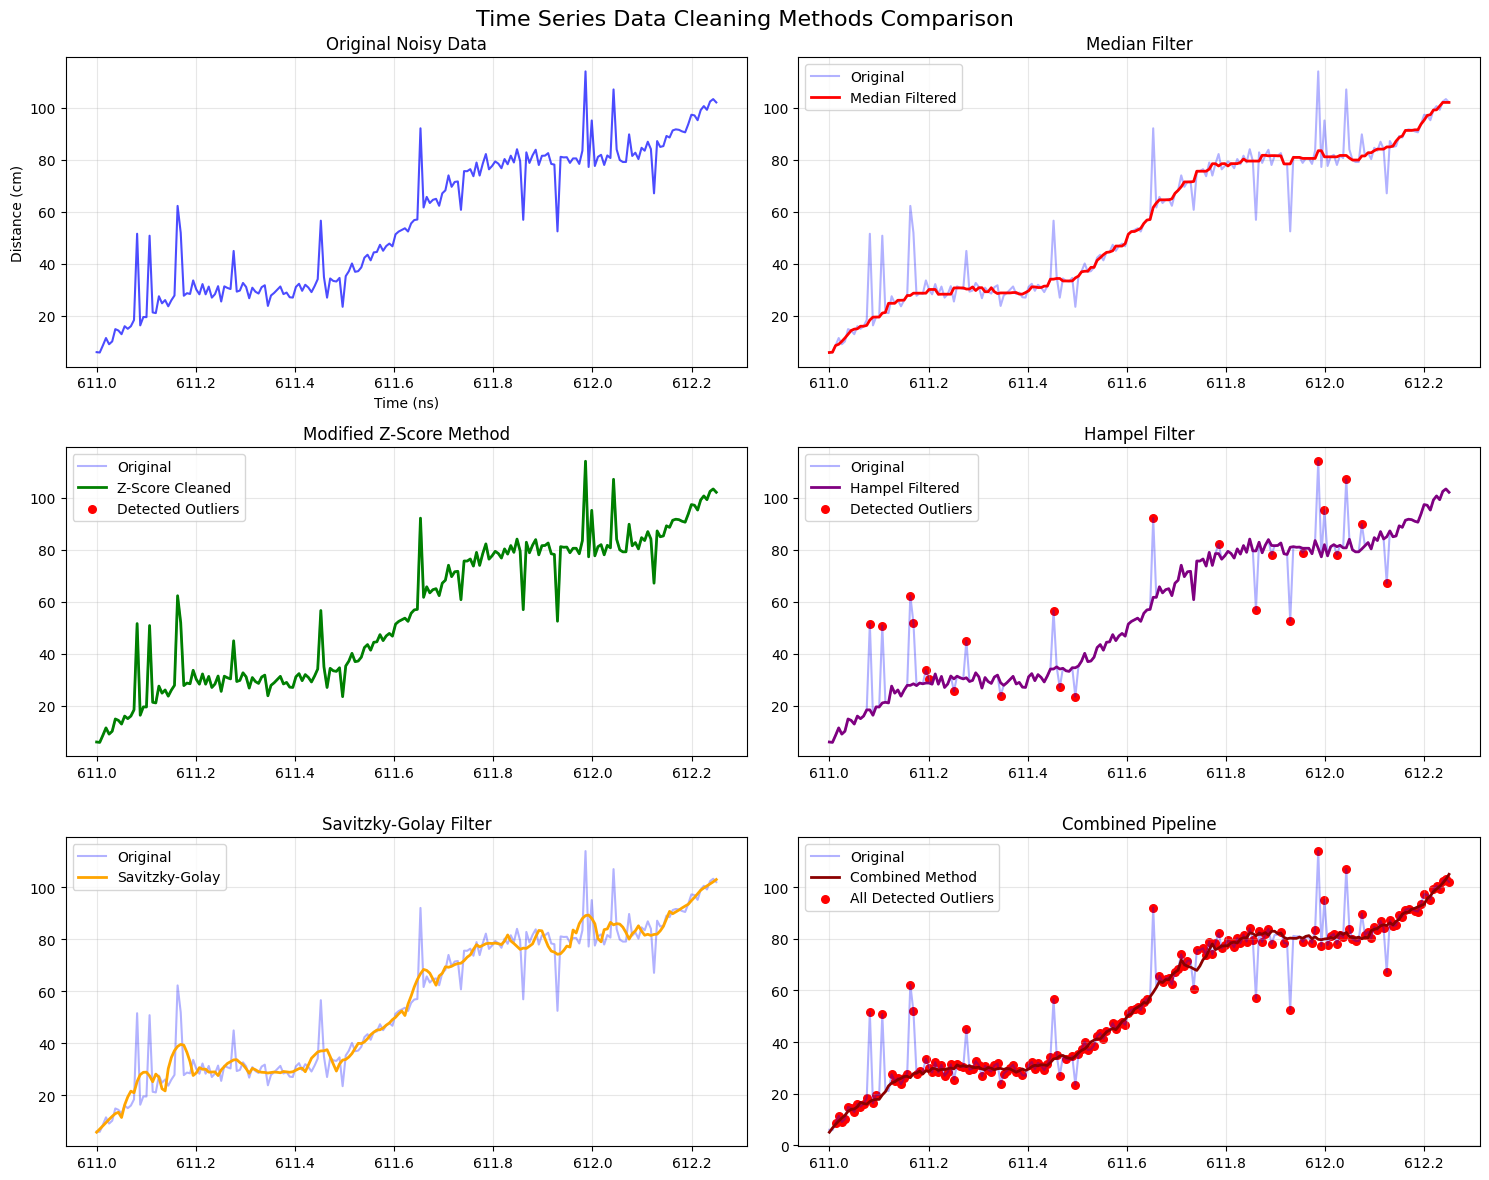

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler

def median_filter_cleaning(data, window_size=5):
    """
    Apply median filter to remove impulse noise.
    Median filters are excellent for removing salt-and-pepper noise.
    """
    return signal.medfilt(data, kernel_size=window_size)

def modified_z_score_cleaning(data, threshold=3.5):
    """
    Remove outliers using Modified Z-Score method.
    More robust than standard Z-score for non-normal distributions.
    """
    median = np.median(data)
    mad = np.median(np.abs(data - median))  # Median Absolute Deviation
    modified_z_scores = 0.6745 * (data - median) / mad
    
    # Create mask for outliers
    outlier_mask = np.abs(modified_z_scores) > threshold
    
    # Replace outliers with interpolated values
    cleaned_data = data.copy()
    cleaned_data[outlier_mask] = np.nan
    
    # Linear interpolation for outliers
    valid_indices = ~np.isnan(cleaned_data)
    if np.sum(valid_indices) > 1:
        cleaned_data = pd.Series(cleaned_data).interpolate(method='linear').values
    
    return cleaned_data, outlier_mask

def hampel_filter(data, window_size=7, threshold=3):
    """
    Hampel filter for outlier detection and removal.
    Uses local median and MAD within a sliding window.
    """
    n = len(data)
    cleaned_data = data.copy()
    outlier_mask = np.zeros(n, dtype=bool)
    
    half_window = window_size // 2
    
    for i in range(half_window, n - half_window):
        window = data[i - half_window:i + half_window + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        
        if mad == 0:
            mad = np.finfo(float).eps  # Avoid division by zero
            
        if np.abs(data[i] - median) > threshold * mad:
            cleaned_data[i] = median
            outlier_mask[i] = True
    
    return cleaned_data, outlier_mask

def savitzky_golay_cleaning(data, window_length=11, polyorder=3):
    """
    Apply Savitzky-Golay filter for smoothing while preserving features.
    Good for data with underlying smooth trends.
    """
    if window_length % 2 == 0:
        window_length += 1  # Must be odd
    
    if len(data) < window_length:
        window_length = len(data) if len(data) % 2 == 1 else len(data) - 1
        
    return signal.savgol_filter(data, window_length, polyorder)

def velocity_based_cleaning(time_data, position_data, max_velocity=50):
    """
    Remove points that would require unrealistic velocity changes.
    Assumes continuous motion with physical constraints.
    """
    cleaned_position = position_data.copy()
    outlier_mask = np.zeros(len(position_data), dtype=bool)
    
    for i in range(1, len(position_data)):
        dt = time_data[i] - time_data[i-1]
        if dt > 0:
            velocity = abs(position_data[i] - position_data[i-1]) / dt
            if velocity > max_velocity:
                # Mark as outlier and interpolate
                outlier_mask[i] = True
                if i == 1:
                    cleaned_position[i] = position_data[i-1]
                else:
                    # Linear interpolation
                    cleaned_position[i] = position_data[i-1] + \
                        (position_data[i-1] - position_data[i-2])
    
    return cleaned_position, outlier_mask

def combined_cleaning_pipeline(time_data, position_data, 
                             median_window=5, 
                             hampel_window=7, 
                             hampel_threshold=3,
                             max_velocity=50):
    """
    Combined approach using multiple methods for robust cleaning.
    """
    # Step 1: Remove extreme outliers with modified Z-score
    stage1, outliers1 = modified_z_score_cleaning(position_data, threshold=3.5)
    
    # Step 2: Apply Hampel filter for local outliers
    stage2, outliers2 = hampel_filter(stage1, hampel_window, hampel_threshold)
    
    # Step 3: Velocity-based filtering
    stage3, outliers3 = velocity_based_cleaning(time_data, stage2, max_velocity)
    
    # Step 4: Final smoothing with Savitzky-Golay
    final_cleaned = savitzky_golay_cleaning(stage3, window_length=11, polyorder=3)
    
    # Combine all outlier masks
    all_outliers = outliers1 | outliers2 | outliers3
    
    return final_cleaned, all_outliers

# Example usage and comparison
def demonstrate_cleaning_methods(time_data, noisy_data):
    """
    Demonstrate different cleaning methods on the same dataset.
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Time Series Data Cleaning Methods Comparison', fontsize=16)
    
    # Original data
    axes[0, 0].plot(time_data, noisy_data, 'b-', alpha=0.7, label='Original')
    axes[0, 0].set_title('Original Noisy Data')
    axes[0, 0].set_xlabel('Time (ns)')
    axes[0, 0].set_ylabel('Distance (cm)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Median filter
    median_cleaned = median_filter_cleaning(noisy_data, window_size=5)
    axes[0, 1].plot(time_data, noisy_data, 'b-', alpha=0.3, label='Original')
    axes[0, 1].plot(time_data, median_cleaned, 'r-', linewidth=2, label='Median Filtered')
    axes[0, 1].set_title('Median Filter')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Modified Z-score
    zscore_cleaned, outliers = modified_z_score_cleaning(noisy_data)
    axes[1, 0].plot(time_data, noisy_data, 'b-', alpha=0.3, label='Original')
    axes[1, 0].plot(time_data, zscore_cleaned, 'g-', linewidth=2, label='Z-Score Cleaned')
    axes[1, 0].scatter(time_data[outliers], noisy_data[outliers], 
                      color='red', s=30, label='Detected Outliers')
    axes[1, 0].set_title('Modified Z-Score Method')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Hampel filter
    hampel_cleaned, hampel_outliers = hampel_filter(noisy_data)
    axes[1, 1].plot(time_data, noisy_data, 'b-', alpha=0.3, label='Original')
    axes[1, 1].plot(time_data, hampel_cleaned, 'purple', linewidth=2, label='Hampel Filtered')
    if np.any(hampel_outliers):
        axes[1, 1].scatter(time_data[hampel_outliers], noisy_data[hampel_outliers], 
                          color='red', s=30, label='Detected Outliers')
    axes[1, 1].set_title('Hampel Filter')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Savitzky-Golay
    savgol_cleaned = savitzky_golay_cleaning(noisy_data)
    axes[2, 0].plot(time_data, noisy_data, 'b-', alpha=0.3, label='Original')
    axes[2, 0].plot(time_data, savgol_cleaned, 'orange', linewidth=2, label='Savitzky-Golay')
    axes[2, 0].set_title('Savitzky-Golay Filter')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Combined approach
    combined_cleaned, all_outliers = combined_cleaning_pipeline(time_data, noisy_data)
    axes[2, 1].plot(time_data, noisy_data, 'b-', alpha=0.3, label='Original')
    axes[2, 1].plot(time_data, combined_cleaned, 'darkred', linewidth=2, label='Combined Method')
    axes[2, 1].scatter(time_data[all_outliers], noisy_data[all_outliers], 
                      color='red', s=30, label='All Detected Outliers')
    axes[2, 1].set_title('Combined Pipeline')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Performance metrics for evaluating cleaning quality
def evaluate_cleaning_quality(original, cleaned, true_signal=None):
    """
    Evaluate the quality of data cleaning.
    """
    metrics = {}
    
    # Signal smoothness (lower is smoother)
    diff1 = np.diff(cleaned)
    diff2 = np.diff(diff1)
    metrics['smoothness'] = np.std(diff2)
    
    # Noise reduction (ratio of variances)
    metrics['noise_reduction'] = np.var(original) / np.var(cleaned)
    
    # Data preservation (how much of original signal is preserved)
    metrics['data_preservation'] = 1 - np.mean(np.abs(original - cleaned)) / np.std(original)
    
    if true_signal is not None:
        # If we know the true signal, calculate MSE
        metrics['mse_improvement'] = (np.mean((original - true_signal)**2) - 
                                    np.mean((cleaned - true_signal)**2))
    
    return metrics

# Example usage:
if __name__ == "__main__":
    # Generate example noisy data similar to your sensor data
    np.random.seed(42)
    time_points = np.linspace(611, 612.25, 200)
    
    # Create underlying smooth signal (toy car movement)
    true_signal = 5 + (time_points - 611) * 80 + 10 * np.sin((time_points - 611) * 10)
    
    # Add noise and outliers
    noise = np.random.normal(0, 2, len(time_points))
    outlier_indices = np.random.choice(len(time_points), size=20, replace=False)
    outliers = np.random.uniform(-30, 40, size=20)
    
    noisy_data = true_signal + noise
    noisy_data[outlier_indices] += outliers
    
    # Apply cleaning methods
    print("Applying different cleaning methods...")
    
    # Individual methods
    median_result = median_filter_cleaning(noisy_data)
    zscore_result, _ = modified_z_score_cleaning(noisy_data)
    hampel_result, _ = hampel_filter(noisy_data)
    savgol_result = savitzky_golay_cleaning(noisy_data)
    combined_result, _ = combined_cleaning_pipeline(time_points, noisy_data)
    
    # Evaluate each method
    methods = {
        'Median Filter': median_result,
        'Modified Z-Score': zscore_result,
        'Hampel Filter': hampel_result,
        'Savitzky-Golay': savgol_result,
        'Combined Pipeline': combined_result
    }
    
    print("\nCleaning Quality Metrics:")
    print("-" * 50)
    for name, cleaned in methods.items():
        metrics = evaluate_cleaning_quality(noisy_data, cleaned, true_signal)
        print(f"{name}:")
        print(f"  Smoothness: {metrics['smoothness']:.3f}")
        print(f"  Noise Reduction: {metrics['noise_reduction']:.2f}x")
        print(f"  Data Preservation: {metrics['data_preservation']:.3f}")
        if 'mse_improvement' in metrics:
            print(f"  MSE Improvement: {metrics['mse_improvement']:.3f}")
        print()
    
    # Create comparison plot
    fig = demonstrate_cleaning_methods(time_points, noisy_data)
    plt.show()